### Setting up environment (optional)

In [ ]:
#@title
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/HW3")

### Imports

In [ ]:
import pandas as pd
import numpy as np
import scipy
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smgraphics
from scipy import stats
from scipy.stats import skew
#from dask_ml.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('telco.txt', sep='\t')

## **Problem 6. In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 3. The variable $tenure$ is taken as the dependent variable and the remaining variables as explanatory.** 


### **1. The lasso regression is an alternative approach to variable selection.**



#### **a) Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.**

The main idea of lasso regression is to introduce penalty term in the form of absolute value of variable parameters sum, multiplied by $\lambda$ to linear regression equation in order to shrink unimportant parameters down to zero (variable selection) and decrease variance of the model. The latter one is also a goal for Ridge Regression.

Simple linear regression fail and lasso can be estimated if number of independent variables is larger than number of observations, as in this case we can construct arbitrary many best-fit hyperplanes through data;

Generally, it is better to use Lasso in cases when we don't know our data well and include a lot of unimportant variables in it.

#### **(b) For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i − x̄)/\hat{\sigma_{x}}$ . Can/should the binary variables be scaled in the same fashion? How would you handle the variable $ed$?**

Lasso Regression introduces a penalty on the coefficients magnitude, but their value depend on the magnitude of each variable. Thus, variables need to be on the same scale, otherwise certain variables may dominate during fitting the model.

In case of the binary variables it would be hard to interpret results if we standardize them. However, standardization may make problem more stable numerically and without risk of penalizing binary variables to much, given their relatively bigger magnitude, as variables will be on the same scale.

I will choose to not standardize our binary variables because of the future interpretation importance. In case of $ed$ I will use simple one-hot encoding as ordinal encoding will be appropriate only when we could compare $ed$ values between each other.

Let's make our X,y and interval varables list:

In [ ]:
y = df.copy()['tenure']
X = df.copy().drop('tenure',axis=1)
interval_vars = ['age','address','income','employ','longmon','wiremon']

Binary encoding for our binary categoricals:

In [ ]:
X['marital'] = X['marital'].apply(lambda val: 1 if val == 'Married' else 0)
X['retire'] = X['retire'].apply(lambda val: 1 if val == 'Yes' else 0)
X['gender'] = X['gender'].apply(lambda val: 1 if val == 'Male' else 0)
X['churn'] = X['churn'].apply(lambda val: 1 if val == 'Yes' else 0)

One-hot encoding for $ed$:

In [ ]:
X = pd.get_dummies(X,drop_first=True)
binary_vars=X.drop(interval_vars,axis=1).columns.tolist()

Standardization of interval-scaled variables:

In [ ]:
#standard scaler with indexes instead of strings
preprocessor = ColumnTransformer(
    transformers=[                   
        ('num', StandardScaler(), interval_vars)
        ], remainder='passthrough')
#X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(preprocessor.fit_transform(X),columns=interval_vars+binary_vars)
cols = X_scaled.columns.tolist()

#### **(c) Run a lasso regression for data with $\lambda ∈ (0, 1)$. Plot the estimated parameters as functions of $α$. Which value of $α$ would you recommend? If it is easy to implement, then determine the optimal $α$ by cross-validation.**

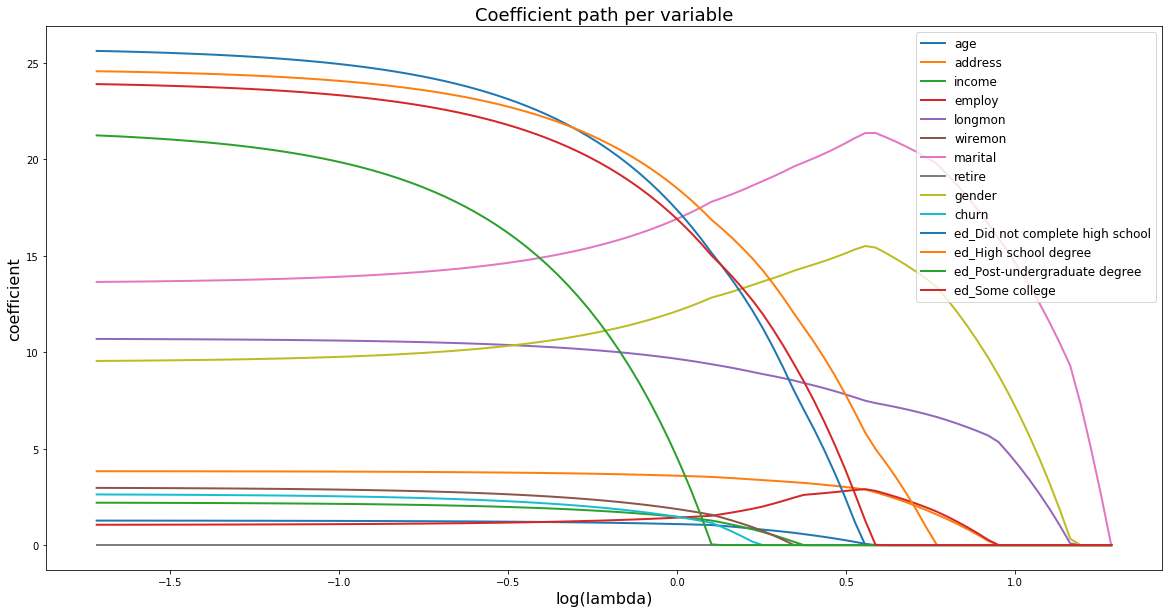

In [ ]:
from sklearn.linear_model import LassoCV
cv_k = 10
LassoReg = LassoCV(cv=cv_k, random_state=0)
LassoReg.fit(X_scaled, y)
alphas, coefs = LassoReg.path(X_scaled, y)[:2]
plt.figure(figsize=(20,10))
plt.title('Coefficient path per variable',fontsize=18)
for i, c in enumerate(coefs):
    #plt.subplot(5,3,i+1)
    #plt.ylabel(str(i)+' '+X_scaled.columns[i], fontsize=11)
    #plt.xlabel('log10(alpha)')
    plt.plot(np.log10(alphas), c,lw=2)
plt.legend(cols,fontsize=12)
plt.xlabel('log(lambda)',fontsize=16)
plt.ylabel('coefficient',fontsize=16)
plt.show()

**Conclusion:**

From just plot of $coefficients$ vs. $log(lambda)$ it is seen that after $log(lambda) > 1$ we are left only with $marital$, $gender$, $longmon$. If we wanted to use the simplest model with more than 1 variable, we can choose $log(lambda)$ slightly bigger than 1. But we can't say whether that's an optimal value by above graph. We need to check our cross-validation results on mean squared error:

Best lambda result is: 0.049892340117913984
Best log(lambda) result is: -2.997887792658731


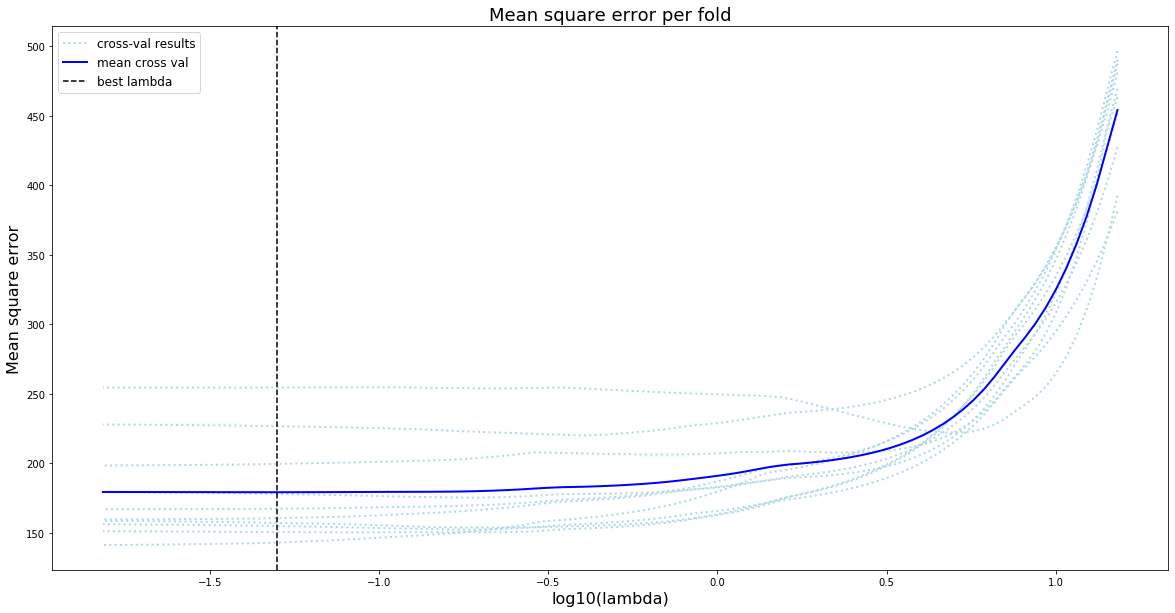

In [ ]:
plt.figure(figsize=(20,10))
alpha = LassoReg.alpha_
print('Best lambda result is:',alpha)
print('Best log(lambda) result is:',np.log(alpha))

m_log_alphas = np.log10(LassoReg.alphas_)
plt.plot(m_log_alphas, LassoReg.mse_path_, ':',linewidth=2,c='lightblue')
plt.plot(m_log_alphas, LassoReg.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2, c='b')
plt.xlabel('log10(lambda)',fontsize=16)
plt.ylabel('Mean square error',fontsize=16)
plt.title('Mean square error per fold',fontsize=18)
plt.axvline(np.log10(alpha), linestyle='--', color='black', label='lambda best')

plt.legend(['cross-val results','_','_','_','_','_','_','_','_','_','mean cross val','best lambda'],fontsize=12)

plt.show()

### **2. A nonlinear regression offers a flexible technique for modelling complex relationships. We wish to explain the $tenure$ by the long distance calls per month $longmon$.**

#### **(a) Make a bivariate scatter plot and estimate an appropriate linear (!) model. Add the regression line to the plot.**


Estimating linear model, where $tenure$ is dependent and $longmon$ is independent:

In [ ]:
X = df['longmon'].copy()
X = sm.add_constant(X)
y = df['tenure'].copy()
model = sm.OLS(y, X)
result = model.fit()

Plotting bivariate scatter plot with a line from above linear model over it:

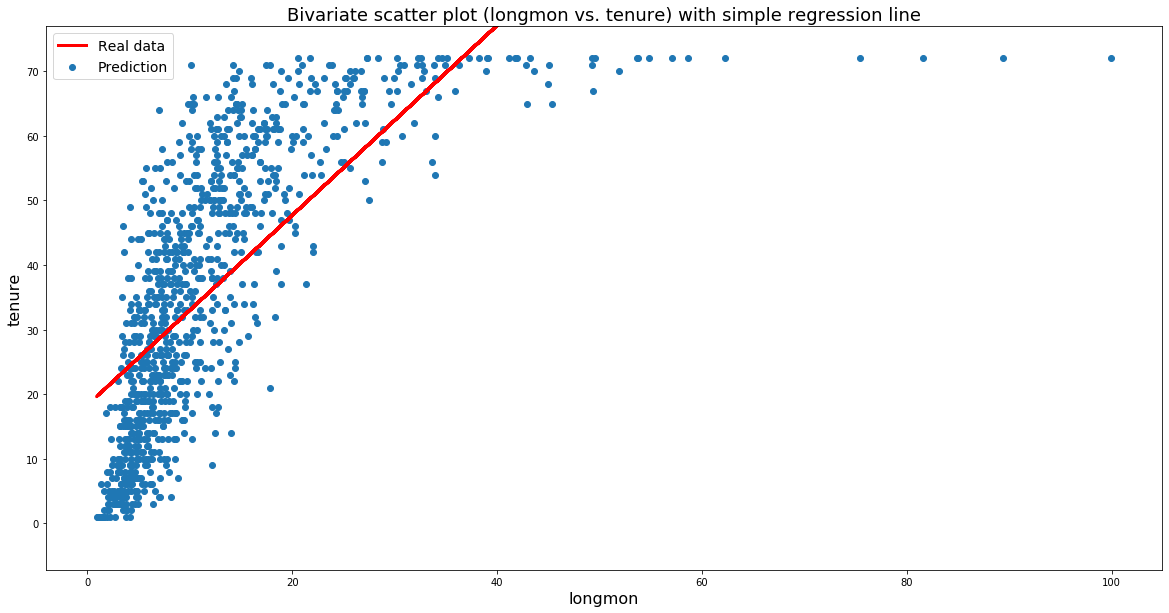

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(df['longmon'],df['tenure'])
plt.plot(X['longmon'],result.predict(X),c='r',linewidth=3)
plt.ylim(top=(df['tenure'].max()+5))
plt.ylabel('tenure',fontsize=16)
plt.xlabel('longmon',fontsize=16)
plt.title('Bivariate scatter plot (longmon vs. tenure) with simple regression line',fontsize=18)
plt.legend(['Real data','Prediction'],fontsize=14)
plt.show()

#### **(b) Estimate now an appropriate nonlinear regression which might fit the data better. Add the regression curve to the plot and compare (quantitatively) the fit with the fit of the linear model.**

The most popular software in Python for non-linear fit is curve_fit from scipy.

In [ ]:
from scipy.optimize import curve_fit
x = np.asarray(X['longmon']).ravel()
y = np.asarray(y).ravel()

I will use function of Weibull growth as it is very similar to what I see on the plot. The Weibull function has a following formula:

$y = \beta_1 + (\beta_2-\beta_1) \cdot e^{-\beta_3\cdot(x^{\beta_4)}}$

In [ ]:
#weibull growth function
def weibull_func(x,a,b,c,d):
    return a+(b-a)*np.exp(-c*(x**d))

Fitting our function:

In [ ]:
popt, pcov = curve_fit(weibull_func, x,y)

Let's plot everything:

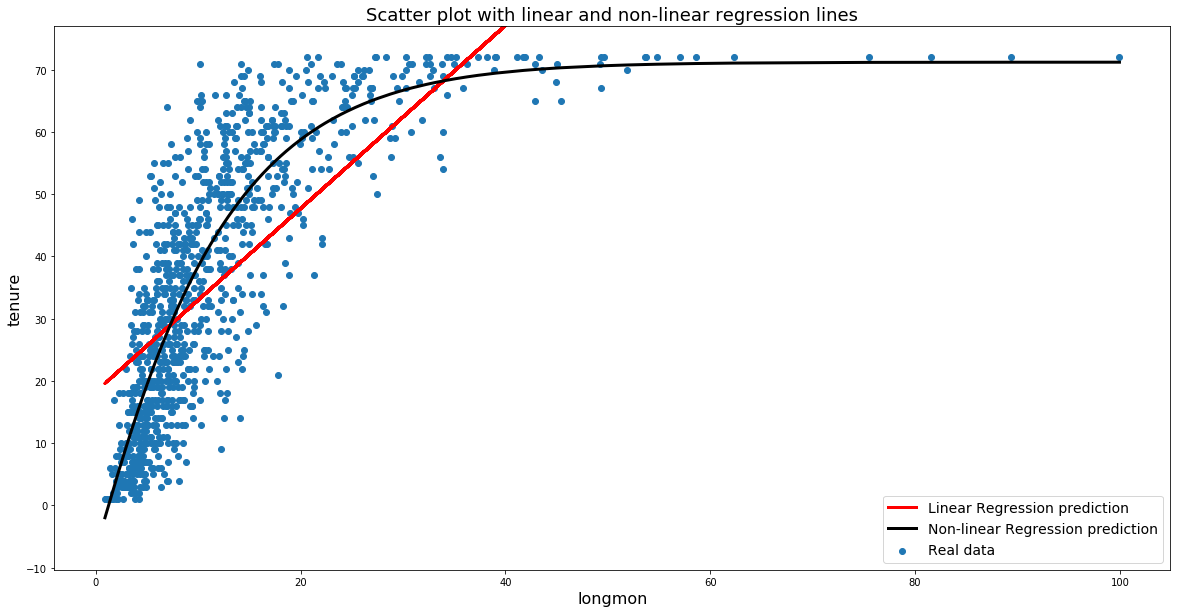

In [ ]:
non_lin_df=pd.DataFrame(weibull_func(x, *popt),columns=['pred'])
non_lin_df['x'] = x
non_lin_df['y'] = y
non_lin_df=non_lin_df.sort_values(by=['pred']).reset_index(drop=True)
plt.figure(figsize=(20,10))
plt.scatter(df['longmon'],df['tenure'])
plt.plot(X['longmon'],result.predict(X),c='r',linewidth=3)
plt.plot(non_lin_df['x'],non_lin_df['pred'],c='black',linewidth=3)
plt.ylim(top=(df['tenure'].max()+5))
plt.ylabel('tenure',fontsize=16)
plt.xlabel('longmon',fontsize=16)
plt.title('Scatter plot with linear and non-linear regression lines',fontsize=18)
plt.legend(['Linear Regression prediction','Non-linear Regression prediction','Real data',],fontsize=14)
plt.show()

Let's compare linear and non-linear models with $MSE$:

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
print("MSE for OLS Regression: {:.3f}".format(mean_squared_error(y, result.predict(X))))
print("MSE for Non-linear Regression: {:.3f}".format(mean_squared_error(non_lin_df['y'], non_lin_df['pred'])))

MSE for OLS Regression: 223.637
MSE for Non-linear Regression: 125.625


**Conclusion:**

We see that $MSE$ is smaller in non-linear regression, so non-linear regression is more accurate here.

#### **(c) Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators.**

We can't do classical hypothesis testing in non-linear regression because of its arbitrary functional form: we can't isolate effect of certain $\beta_k$ parameter only for certain one variable with classical test while we need to devise some unique null hypothesis test for each variable. Our classical null hypothesis in linear case is that parameter for independet variable $\beta_k=0$ and when it's rejected/not rejected (p-value>=<0.05) and this is general test for each variable. In non-linear regression that would be impossible. For instance, in case of our above equation $\beta_1 + (\beta_2-\beta_1) \cdot e^{-\beta_3\cdot(x^{\beta_4)}}$ .

#### **(d) What kind of problems might arise if we decide to fit a non-linear regression using all explanatory variables?**

- Problem of non-convergence or convergence to local optima: the more complex is the model the more difficult is too converge and too provide first reasonable initial guesses to iterative process;

- Problem of overfitting: if model is non-linear and include a lot of unsignificant variables we risk to fit model to noise.

### **3. Next we model the relationship between $tenure$ and $longmon$ using the nonparametric Nadaraya-Watson regression.**

#### **(a) An important calibration parameter of a nonparametric regression is the bandwidth. Explain what happens with the regression/the weights in the Nadaraya-Watson regression if the bandwidth is too high or too small.**

The bandwidth is a smoothing parameter in non-parametric regression. 

Thus, low bandwidth leads to smaller bias, but if bandwidth is too small, our predictions from the model are just an average over couple of observations,which results in higher amount of noise, i.e. variance is high.

On the contrary, if bandwidth too big, we are smoothing over a large
number of points, which will likely result in bias, since our prediction is from our points just being averaged. This doesn't account for the distribution shape. 

#### **(b) Fit a Nadaraya-Watson regression with Gaussian kernel and “optimal” bandwidth to the $tenure/longmon$ data. Check and explain how the “optimal bandwidth” is determined in your software. Compare the (in-sample) fit of the nonparametric regression and the nonlinear regression in the previous subproblem.**

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg

In [ ]:
kr = KernelReg(y, x, var_type='c')
print('Optimal bandwidth is {:.2f}'.format(kr.bw[0]))

Optimal bandwidth is 2.29


Statsmodels $KernelReg$ function performs least-squares cross validation by default. In least-squares cross validation we are minimizing mean integrated squared error ($MISE$):

$MISE = \mathbb{E}(ISE)$

,where

$ISE = \int_{\infty}^{\infty} [\hat f(y)-f(y)]^2dy$

,where

$\hat f(y) = \frac{1}{n}\sum_{i=1}^{n}K_{h}(x_i,y)$, i.e. kernel estimator, kernel density estimator, indexed by smoothing parameter $h$.

Let's compare our non-linear regression (fitted Weinbull function) and non-parametric Nadaraya regression.

Plotting curves of both prediction:

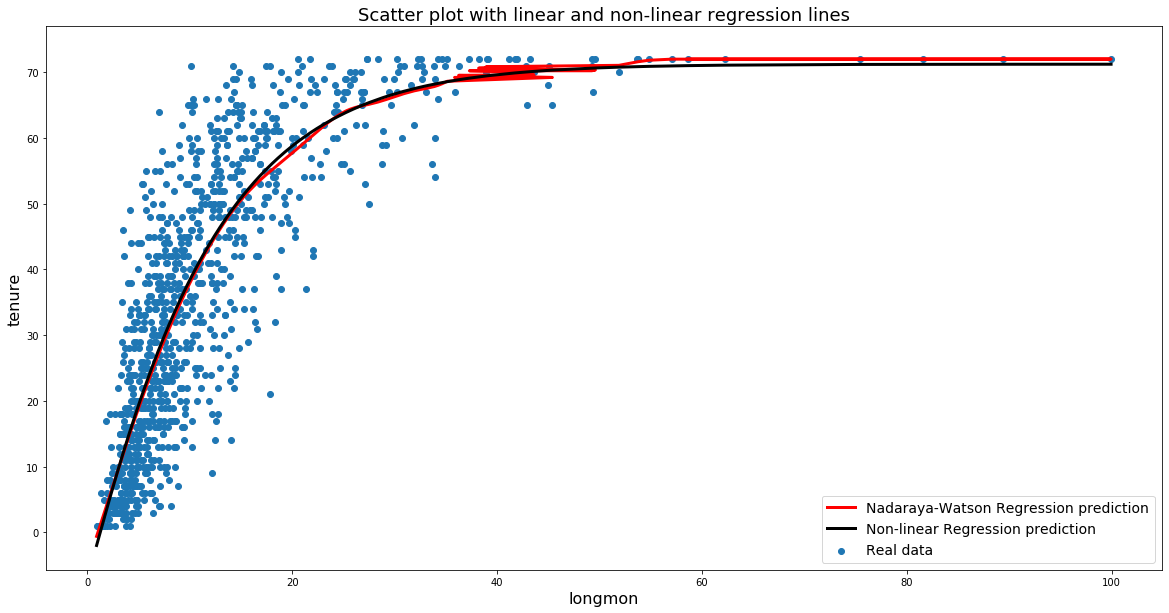

In [ ]:
nadaraya_df=pd.DataFrame(kr.fit(x)[0],columns=['pred'])
nadaraya_df['x'] = x
nadaraya_df['y'] = y
nadaraya_df=nadaraya_df.sort_values(by=['pred']).reset_index(drop=True)

plt.figure(figsize=(20,10))
plt.scatter(df['longmon'],df['tenure'])
pred_nadaraya = kr.fit(x)[0]
plt.plot(nadaraya_df['x'],nadaraya_df['pred'],c='red',linewidth=3)
plt.plot(non_lin_df['x'],non_lin_df['pred'],c='black',linewidth=3)
plt.ylim(top=(df['tenure'].max()+5))
plt.ylabel('tenure',fontsize=16)
plt.xlabel('longmon',fontsize=16)
plt.title('Scatter plot with linear and non-linear regression lines',fontsize=18)
plt.legend(['Nadaraya-Watson Regression prediction','Non-linear Regression prediction','Real data',],fontsize=14)
plt.show()

Let's compare their insample fits with mean squared error ($MSE$):

In [ ]:
print("MSE for Nadaraya-Watson Regression: {:.3f}".format(mean_squared_error(nadaraya_df['y'], nadaraya_df['pred'])))
print("MSE for Non-linear Regression: {:.3f}".format(mean_squared_error(non_lin_df['y'], non_lin_df['pred'])))

MSE for Nadaraya-Watson Regression: 125.640
MSE for Non-linear Regression: 125.625


**Conclusion:**

Seems like in-sample fit is identical for both regressions.

### **4. Next we consider classification of the clients using the $churn$ variable as the dependent variable and the logistic regression.**

#### **(a) Fit a logistic regression to explain churn by the remaining explanatory variables.**

I would use unstandardized version of independent variables in Logistic Regression, so let's recreate all procedures again:

In [ ]:
X = df.copy()
X['marital'] = X['marital'].apply(lambda val: 1 if val == 'Married' else 0)
X['retire'] = X['retire'].apply(lambda val: 1 if val == 'Yes' else 0)
X['gender'] = X['gender'].apply(lambda val: 1 if val == 'Male' else 0)
X['churn'] = X['churn'].apply(lambda val: 1 if val == 'Yes' else 0)
y = X.copy()['churn']
X = X.drop('churn',axis=1)
X = pd.get_dummies(X,drop_first=True)

Fitting model:

In [ ]:
X_ = sm.add_constant(X)
LogR = sm.Logit(y, X_).fit(random_state=42)
LogR.summary()

Optimization terminated successfully.
         Current function value: 0.479359
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           14
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.1836
Time:                        19:55:49   Log-Likelihood:                -479.36
converged:                       True   LL-Null:                       -587.20
Covariance Type:            nonrobust   LLR p-value:                 3.392e-38
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.9299      0.382      2.437      0.015       0.182       1.678
tenure                             -0.0317      0.007     -4.485      0.000      -0.046      -0.018
age                                 0.0007      0.011      0.066      0.947      -0.021       0.022
marital                             0.0442      0.163      0.270      0.787      -0.276       0.365
address                            -0.0147      0.013     -1.146      0.252      -0.040       0.010
income                              0.0005      0.001      0.493      0.622      -0.002       0.003
employ                             -0.0322      0.015     -2.124      0.034      -0.062      -0.002
retire                             -0.6151      0.691     -0.891      0.373      -1.969       0.739
gender                             -0.0706      0.160     -0.442      0.659      -0.384       0.242
longmon                            -0.0385      0.022     -1.771      0.077      -0.081       0.004
wiremon                             0.0141      0.004      3.314      0.001       0.006       0.022
ed_Did not complete high school    -0.7927      0.271     -2.926      0.003      -1.324      -0.262
ed_High school degree              -0.5490      0.223     -2.458      0.014      -0.987      -0.111
ed_Post-undergraduate degree        0.1387      0.316      0.439      0.661      -0.481       0.758
ed_Some college                    -0.3753      0.227     -1.656      0.098      -0.819       0.069
===================================================================================================
"""

#### **(b) Consider the explanatory variable $tenure$. Obviously its parameter cannot be interpreted in the same way as for a linear regression. Provide the correct interpretation using the parameter and using odds.**

Let's extract parameter of $tenure$ from fitted model:

In [ ]:
LogR.params.tenure

-0.031690765128307784

It basically means, given all other variables are fixed, that after increasing $tenure$ by one unit log-odds of $churn$ will decrease by ~ $0.032$. We can convert log-odds to odds by exponentiation:

In [ ]:
from math import exp
exp(-0.032)

0.9685065820791976

This result says that, holding all the other variables fixed, after one unit increase of $tenure$ the odds of $churn$ decrease by ~ $0.04$.

#### **(c) Run a stepwise model selection using AIC as criterion. Further consider only the optimal model chosen here. From the final model, which of the variables do increase the probability of churn and which variables decrease this probability? Is this consistent with economic intuition?**

Let's write stepwise model selection function (I'm using here the same idea as in Assignment#3) with $AIC$ as main criterion:

In [ ]:
#all names of our indep.vars
ind_var_names = X.columns.tolist()

#function
def stepwise_selection(X, y, regressors_left):
    #creating an empty list for selected regressors
    regressors_selected = []
    #creating empty list for scores
    scores_selected = []
    #creating default starting best score as np.inf as its bigger than any future scores and suitable for starting loop
    best_score = np.inf 
    #assigning current score to starting best score
    score = best_score
    #looping until either all independent variables are used in all possible combinations or when further fit give no
    #improvement in AIC 
    while regressors_left != [] and score==best_score:
        regressor_score = []
        for regressor in regressors_left:
            X_selected = X.loc[:, regressors_selected+[regressor]]
            X_selected_ = sm.add_constant(X_selected)
            model_res = sm.Logit(y, X_selected_).fit()
            s = model_res.aic
            regressor_score.append(s)
        i = np.argmin(regressor_score) 
        score = regressor_score[i]
        if (score < best_score):
            best_score = score 
            regressors_selected.append(regressors_left[i])
            scores_selected.append(score)
            del regressors_left[i]
    last_var = regressors_left[i]
    last_score = score
    print('Stepwise selection with AIC picked {} independent variables:\n{}'.format(len(regressors_selected), regressors_selected))
    return regressors_selected,last_var,scores_selected,last_score

regressors_selected,last_reg,scores_selected,last_score = stepwise_selection(X, y, ind_var_names)

Let's plot $AIC$:

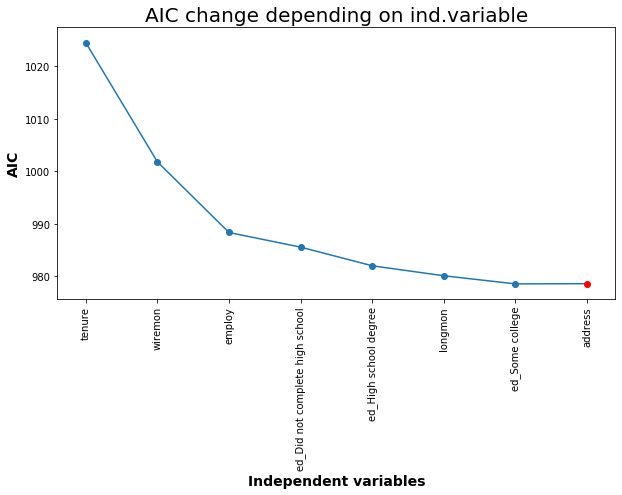

In [ ]:
x_ax = regressors_selected+[last_reg]
y_ax = scores_selected+[last_score]
plt.figure(figsize=(10,5))
plt.plot(x_ax, y_ax)
plt.scatter(x_ax[:-1], scores_selected)
plt.scatter(x_ax[-1], last_score, color='r', zorder=10)
plt.xticks(rotation='vertical')
plt.xlabel('Independent variables',fontsize=14,fontweight='bold')
plt.ylabel('AIC',fontsize=14,fontweight='bold')
plt.title('AIC change depending on ind.variable',fontsize=20)
plt.show()

**Conclusion:**

$AIC$ stops decreasing after addition of $address$ variable, so we will go further with:

In [ ]:
regressors_selected

['tenure',
 'wiremon',
 'employ',
 'ed_Did not complete high school',
 'ed_High school degree',
 'longmon',
 'ed_Some college']

Creating new model with those chosen variables:

In [ ]:
X_sel = X.loc[:, regressors_selected]
X_sel = sm.add_constant(X_sel)
new_model = sm.Logit(y, X_sel)
result = new_model.fit()

Optimization terminated successfully.
         Current function value: 0.481285
         Iterations 7


Coefficients, that increase churn probability are:

In [ ]:
result.params[result.params>0]

const      0.932948
wiremon    0.014589
dtype: float64

Coefficients, that decrese churn probability are:

In [ ]:
result.params[result.params<0]

tenure                            -0.032723
employ                            -0.034111
ed_Did not complete high school   -0.851569
ed_High school degree             -0.599885
longmon                           -0.041105
ed_Some college                   -0.402115
dtype: float64

I think that $tenure$ decreasing churn probability is consistent with economic intuition for this type of market, as the longer client uses some telephone service the more it becomes habituated to it. 

If $employ$ means how long client has been at current job (this variable wasn't explained in Task), then it is also understadable why it decreases churn probability. The more stability is in job the more probability that client won't have economic incentive to stop leaving telephone operator services.

#### **(d) Randomly pick up ﬁve clients. Determine their probabilities of leaving the company. Provide for the ﬁrst of them the formula which may be used to compute this probability with inserted values of parameters and variables. If you want to predict the membership in one of the two groups for a particular client, what is the simplest way to proceed using these probabilities?**

Let's randomly pick 5 client id's:

In [ ]:
np.random.seed(42)
id_clients = np.random.randint(1,len(X),5)
print("Chosen id's of clients:{}".format(id_clients))

Chosen id's of clients:[103 436 861 271 107]


Computing probability of churn:

In [ ]:
for client in id_clients:
    print('For client {} probability of leaving the company is:'.format(client),result.predict(X_sel.loc[X_sel.index==client]).values[0])

For client 103 probability of leaving the company is: 0.38326454191346077
For client 436 probability of leaving the company is: 0.44373559552432895
For client 861 probability of leaving the company is: 0.3707210229611125
For client 271 probability of leaving the company is: 0.1865980993907954
For client 107 probability of leaving the company is: 0.17050384759984724


The first client is with id=$103$. We have next values for params of this client:

In [ ]:
pd.concat([result.params,X_sel.iloc[102]],axis=1)

,0,103
const,0.932948,1.0
tenure,-0.032723,12.0
wiremon,0.014589,0.0
employ,-0.034111,0.0
ed_Did not complete high school,-0.851569,1.0
ed_High school degree,-0.599885,0.0
longmon,-0.041105,4.0
ed_Some college,-0.402115,0.0


Given formula for logistic regression model, for the client with 
id=$103$ the probability of churn would be:

$ p(y=1|x=103) = g\left(\beta^{\mathrm{T}} x_{103}\right) = \frac{1}{1+e^{-(\beta_{0} + \beta_{1}x_1 + \beta_{2}x_2 + \beta_{3}x_3 + \beta_{4}x_4 + \beta_{5}x_5 + \beta_{6}x_6 + \beta_{7}x_7)}} 
= \frac{1}{1+e^{-(0.932948-0.032723(12.0) + 0.014589(0.0)-0.034111(0.0) -0.851569(1.0) -0.599885(0.0) -0.041105(4.0) -0.402115(0.0))}} = \frac{1}{1+e^{-(−0,475717)} } = \frac{1}{1+1.609167557} = 0.383264$

,which is consistent with statsmodels package pre-computed value.

The most common way (implemented by default in Python libraries) way to determine the group of client would be to establish a threshold of $0.5$: 

if probability > $0.5$ then client is in $churn$, otherwise he/she is not in $churn$. 

#### **(e) Compute the classiﬁcation table and calculate the specifity and sensitivity. Provide verbal interpretation for the elements of the classiﬁcation table and the performance measures.**

Let's calculate classification table:

In [ ]:
table_arr=result.pred_table(0.5)
sum_true_arr = np.sum(result.pred_table(0.5),axis=0)
final_col=np.vstack((table_arr,sum_true_arr))
data=pd.DataFrame(final_col,columns=['Fail-Obs','Success-Obs'],index=['Fail-Pred','Success-Pred','sum'])
data['sum'] = data['Fail-Obs'] + data['Success-Obs']
data.iloc[2,2]='_'
data

,Fail-Obs,Success-Obs,sum
Fail-Pred,670.0,56.0,726
Success-Pred,172.0,102.0,274
sum,842.0,158.0,_


In classification table above: 
- 'Fail-Obs' - number of true non-churned users, 
- 'Success-Obs' - number of true churned users, 
- 'Fail-Pred' - number of predicted non-churned users,
- 'Success-Pred' - number of predicted churned users.

For pairs:

- pair 'Fail-Obs'-'Fail-Pred' is **True Negative (TN)**;
- pair 'Fail-Obs'-'Success-Pred' is **False Positive (FP)**;
- pair 'Success-Obs'-'Fail-Pred' is **False Negative (FN)**;
- pair 'Success-Obs'-'Success-Pred' is **True Positive (TP)**.

Given above definitions, **Specificity** is calculated with following formula:

$
\frac{TN}{TN+FP}
$

Specificity measures the ratio of correctly classified negatives to all negatives (sum of correctly and incorrecly classified negatives), i.e. measures proportion of actual negatives that were identified. In our case, negatives are people that are not leaving the telephone company.

Let's calculate it from the above-described elements of classification table:

In [ ]:
print('Specificity is:',670/842)

Specificity is: 0.7957244655581948


**Sensitivity** is calculated with following formula:

$
\frac{TP}{TP+FN}
$

Sensitivity measures the ratio of correctly classified positives to all positives (correct+incorrect), i.e. measures proportion of actual positives that were identified. In our case, positives are people that are leaving the telephone company.

Let's calculate it from the above-described elements of classification table:

In [ ]:
print('Sensitivity is:',102/158)

Sensitivity is: 0.6455696202531646


#### **f) To improve the performance it makes sense to change the threshold used for classification. This can be done using the ROC curve. Plot this curve and determine the optimal threshold.**

We will use Youden's J statistic to find our optimal threshold value. Geometrically this statistic corresponds to the point on plot where the distance between ROC curve of Random guess line and ROC curve of classifier (Logistic Regression in our case) is the biggest one. The index gives equal weight to false positive and false negative values

The formula for this statistic is:

$
J = Sensitivity+Specificity-1
$

Let's find this point and plot ROC curve.

Function for Youden's J-statistic:

In [ ]:
def cutoff_youdens_j(fpr,tpr,thresholds):
    """
    fpr- false positive rate of classifier;
    tpr- true positive rate of classifier (recall);
    thresholds- values of possible thresholds;
    return- the max value of computed J-statistic values
    """
    #find array of j-statistics
    j_scores = tpr-fpr
    #sort j-scores and zip them with thresholds in ascending order
    j_ordered = sorted(zip(j_scores,thresholds))
    #get optimal threshold
    optimal_threshold = j_ordered[-1][1]
    #get biggest j-statistic value
    max_j_statistic = j_ordered[-1][0]
    #get index of tpr-fpr pair for this value
    j_dict = dict(enumerate(j_scores))
    sorted_j_dict = sorted(j_dict.items(), key=lambda kv: kv[1])
    max_idx = sorted_j_dict[-1][0]
    #get fpr value for this index to plot vertical line on ROC curve plot and get lower bound
    fpr_optimal = fpr[max_idx]
    #get tpr value for this index to get upper bound and point on ROC curve
    tpr_optimal = tpr[max_idx]
    #return 
    return optimal_threshold,max_j_statistic,max_idx,fpr_optimal,tpr_optimal

Let's implement function and plot ROC curves of our Logistic Regression Classifier, Random Guess Classifier and vertical line, which corresponds to Youden's j-statistic (biggest distance from our classifier to Random Guess):

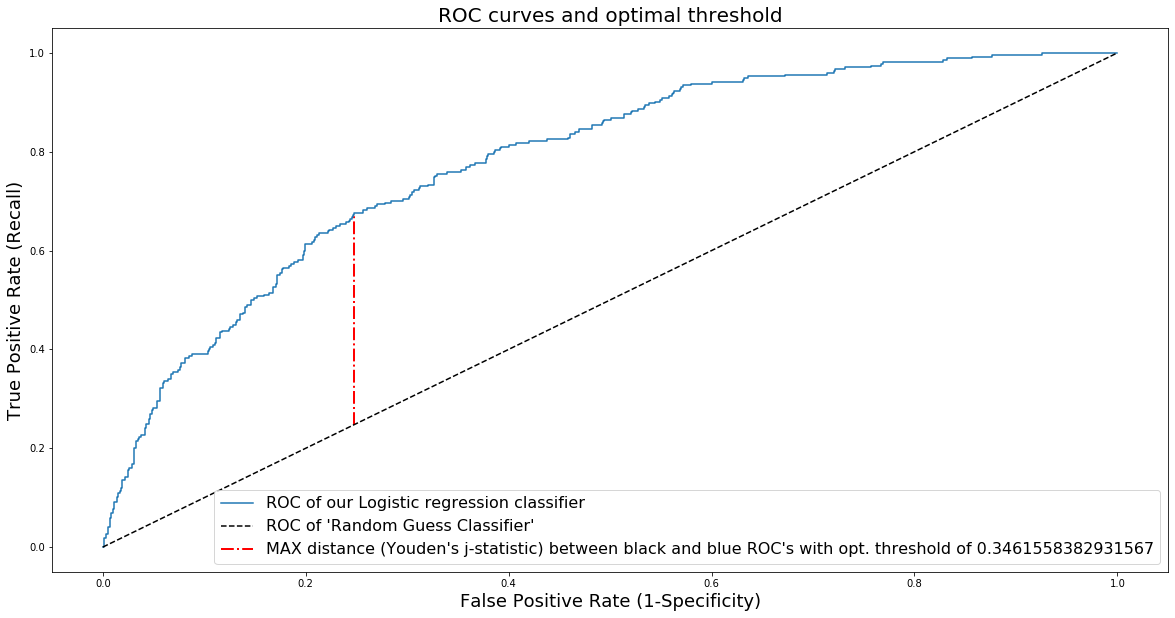

Our optimal threshold, given by Youden's j-statistic is 0.3461558382931567


In [ ]:
from sklearn.metrics import roc_curve
#compute probability of churn for each user
probs = result.predict(X_sel)
#compute false positive, true positive rates and possible thresholds
fpr, tpr, thresholds = roc_curve(y, probs)
#compute j-statistic
optimal_threshold,max_j_statistic,max_idx,fpr_optimal,tpr_optimal = cutoff_youdens_j(fpr,tpr,thresholds)
#figure size
plt.figure(figsize=(20,10))
#plot roc curve for logistic regression classifier
plt.plot(fpr, tpr)
#plot roc curve for random guess (chance line)
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
#plot vertical line for j-statistic point
plt.vlines(fpr_optimal, ymin=fpr_optimal, ymax=tpr_optimal, linestyle='-.',colors='red', lw=2)
#plot configuration
plt.title("ROC curves and optimal threshold",fontsize=20)
plt.ylabel('True Positive Rate (Recall)',fontsize=18)
plt.xlabel('False Positive Rate (1-Specificity)',fontsize=18)
plt.legend(['ROC of our Logistic regression classifier',"ROC of 'Random Guess Classifier'","MAX distance (Youden's j-statistic) between black and blue ROC's with opt. threshold of {}".format(optimal_threshold)],fontsize=16)
plt.show()
print("Our optimal threshold, given by Youden's j-statistic is {}".format(optimal_threshold))

**Conclusion**:
 If using Youden's j-statistic as a criterion our threshold for Logistic Regression classifier should be $0.3461558382931567$, not $0.5$.

#### **(g) Recompute the classification table, sensitivity and specificity for the new threshold. Provide interpretation of the obtained values. Compare the results with the original values. Is the procedure now more strict/conservative?**

Recomputing our classification table:

In [ ]:
table_arr=result.pred_table(optimal_threshold)
sum_true_arr = np.sum(result.pred_table(optimal_threshold),axis=0)
final_col=np.vstack((table_arr,sum_true_arr))
data=pd.DataFrame(final_col,columns=['Fail-Obs','Success-Obs'],index=['Fail-Pred','Success-Pred','sum'])
data['sum'] = data['Fail-Obs'] + data['Success-Obs']
data.iloc[2,2]='_'
data

,Fail-Obs,Success-Obs,sum
Fail-Pred,546.0,180.0,726
Success-Pred,90.0,184.0,274
sum,636.0,364.0,_


Recomputing specificity:

In [ ]:
print('Specificity is:',546/636)

Specificity is: 0.8584905660377359


Recomputing sensitivity:

In [ ]:
print('Sensitivity is:',184/364)

Sensitivity is: 0.5054945054945055


**Conclusion**:

By relaxing threshold from $0.5$ to ~$0.35$:
- we have increased $specificity$ of model from ~$0.796$ to $0.86$, 
- but we also significantly decreased $sensitivity$ of model from ~$0.64$ to $0.505$.

It means that the model became more strict: it identifies more clients that won't leave the company.

### **5. In the next step we model $tenure$ using regression trees.**

#### **a) Assume the first variable to be used for splitting is $longmon$. Write down the corresponding optimization problem and explain how the optimization works.**

We can use Weighted Mean Squared Error function as an objective (loss) function in order to find out the best threshold value $T$ of $longmon$ for the first split of data. 

We can write down this as optimization problem in the following manner:

$
minimize
$
$
L(T) = MSE(P_{left}(T))\frac{n_{left}}{N}+MSE(P_{right}(T))\frac{n_{right}}{N} 
$

,where

$
MSE(P) = \frac{1}{N_{P}} \sum_{i \in P}(y_{i} - \bar{y})^{2};
\\
P_{left}(T)=\{(x, y) | x_{longmon}\leq T\};
\\
P_{right}(T)=\{(x, y) | x_{longmon}>T\};
$
a.k.a. Mean Squared Error in the node;

$P_{left}(T)$ or $P_{right}(T)$ - data for the left or right node after splitting using threshold value $T$;
    
$T$ - threshold value for $longmon$;
    
$(x, y)$ - samples (instances of data);
    
$N$ - total number of samples;

$n_{right}$ or $n_{left}$ - number of samples in right or left node;

$\bar{y}$ - average value of $y$ for the right or left node;


**Explanation**:

Optimization works by finding the threshold value of $T$ that splits data to the $right$ and $left$ nodes in a such manner that Mean Squared Error (MSE) of left and right node, weighted by proportion of samples in corresponding nodes, are minimum across all thresholds. 

#### **(b) Obviously you can get very long trees. Tree prunning helps to get trees of a reasonable size. Fit a CART to the data and prune it to have at most 10 splits. What is the value of the corresponding complexity parameter? Check you software for the implementation of the prunning, particularly the form of the loss function.**

In [ ]:
X = df.copy()
X['marital'] = X['marital'].apply(lambda val: 1 if val == 'Married' else 0)
X['retire'] = X['retire'].apply(lambda val: 1 if val == 'Yes' else 0)
X['gender'] = X['gender'].apply(lambda val: 1 if val == 'Male' else 0)
X['churn'] = X['churn'].apply(lambda val: 1 if val == 'Yes' else 0)
y = X.copy()['tenure']
X = X.drop('tenure',axis=1)
X = pd.get_dummies(X,drop_first=True)

Software doesn't implement pruning directly, but it computes effective complexity parameter per split. Thus, we can do the following:

- compute all Decision Tree;

- compute comlexity path of Decision Tree;

- plot Number of leaves vs effective alpha per split. We know that maximum number of leaf nodes will always be equal to num_splits+1. In our case - $11$;

- find complexity value that corresponds to max number of nodes = 11 and plot it.

In [ ]:
from sklearn.tree import DecisionTreeRegressor,plot_tree
clf = DecisionTreeRegressor(criterion='mse', splitter='best',
                            )
clf = clf.fit(X, y)
y_pred = clf.predict(X)
#print("MSE for CART Regression: {:.3f}".format(mean_squared_error(y, y_pred)))

We can compute effective complexity parameter per each split and then plot it against number of leaves (# of splits+1):

Optimal effective alpha for 10 splits is:  2.023327435787607


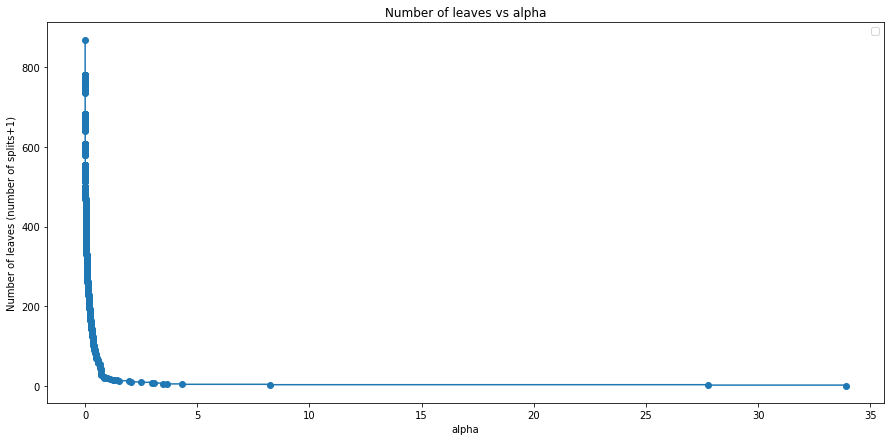

In [ ]:
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
plt.figure(figsize=(15,7))
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
n_leaves_ = [clf.tree_.n_leaves for clf in clfs]
plt.plot(ccp_alphas, n_leaves_, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("Number of leaves (number of splits+1)")
plt.title("Number of leaves vs alpha")
plt.legend(['_',''])
fig.tight_layout()
print('Optimal effective alpha for 10 splits is: ',ccp_alphas[n_leaves_.index(11)])

Effective $\alpha$ (complexity parameter is computed in the following manner):

$\alpha_{eff} = \frac{R(t)-R(T_t)}{|T|-1}$

,where

$R(t)$ - total error for single node;

$R(T)$ - total error of terminal nodes;

$|T|$ - number of terminal nodes.

Fitting tree with optimal number of $\alpha_{eff}$:

In [ ]:
clf = DecisionTreeRegressor(criterion='mse', splitter='best',
                            ccp_alpha=ccp_alphas[n_leaves_.index(11)])
clf = clf.fit(X, y)
y_pred = clf.predict(X)

#### **(c) Check the value of the improvement in the first split. Explain the idea of improvement and provide numerical expression how this improvement is computed for the first split.**

Let's plot first two nodes of the tree:

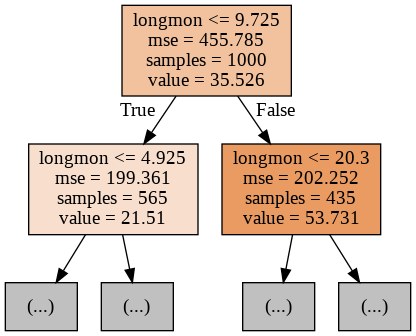

In [ ]:
out = tree.export_graphviz(clf, feature_names=list(X), max_depth=1,filled=True)
graph= pydot.graph_from_dot_data(out)
Image(graph[0].create_png())

The value of improvement, paradoxically, generally, is not computed during CART fitting variance reduction procedure in sklearn. It is because algorithm:
- firstly performs optimization procedure, defined in **(a)**, per each variable, i.e. finds optimal threshold $T$ for each variable;
- then it just chooses such variable, which has the lowest loss function $L$ at its optimal split.

Nevertheless, we can define value of improvement as:

$MSE_{parent} - L(opt)$

,where

- $MSE_{parent}$ - mean squared error for parent node, which value for $\hat y$ is just a mean value $\bar y$ across all $y_i$,

- $L(opt)$ - loss function of optimal variable at its optimal split point;

If calculating L according to **(a)** we've got $200.618$.

So, value of improvement is:

$455.785 - 200.618 = 255.166$.

#### **(d) Compare the in-sample fit of the tree to the in-sample fit of the lasso regression above. Compare the importance of the variables for the two models. In the case of the lasso regression the importance is mirrored by the parameters if the variables are standardized.**

Comparing $MSE$ in-sample performance:

In [ ]:
print("MSE for Lasso regression: {:.3f}".format(mean_squared_error(y,LassoReg.predict(X_scaled))))
print("MSE for Decision Tree regression: {:.3f}".format(mean_squared_error(y, clf.predict(X))))

MSE for Lasso regression: 172.396
MSE for Decision Tree regression: 110.728


**Conclusion:**

Seems like Decision Tree is more better model in terms of $MSE$.

In $Lasso$ we have not standardized all variables (left binary untouched), so we won't just simply use parameters as importances.



Let's instead use Permutation importance algorithm (eli5 library), which works in the following manner:

It looks at how much the score decreases when a feature is not available. It replaces feature in the test set with random noise, re-train the estimator and check the score.

Install and import eli5:

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Let's look at feature importances for Decision Tree and Lasso with most important features being at the top:

- **Decision Tree feature importances:**

In [ ]:
perm = PermutationImportance(clf).fit(X, y)
eli5.show_weights(perm,feature_names=list(X))

Weight,Feature
1.2952 ± 0.0460,longmon
0.0546 ± 0.0136,employ
0.0268 ± 0.0052,address
0.0141 ± 0.0068,churn
0 ± 0.0000,ed_Some college
0 ± 0.0000,ed_Post-undergraduate degree
0 ± 0.0000,ed_High school degree
0 ± 0.0000,ed_Did not complete high school
0 ± 0.0000,wiremon
0 ± 0.0000,gender


- **Lasso feature importances:**

In [ ]:
perm = PermutationImportance(LassoReg).fit(X_scaled, y)
eli5.show_weights(perm,feature_names=list(X_scaled))

Weight,Feature
0.5519 ± 0.0371,longmon
0.0466 ± 0.0076,churn
0.0461 ± 0.0092,address
0.0340 ± 0.0074,employ
0.0215 ± 0.0068,age
0.0192 ± 0.0070,retire
0.0093 ± 0.0081,marital
0.0082 ± 0.0018,wiremon
0.0010 ± 0.0014,ed_Post-undergraduate degree
0.0010 ± 0.0006,income


**Conclusion:**

We see that both regression models are in agreement that top-4 important features include $longmon$,$churn$,$address$,$employ$. However order of importances in algorithms are different.